In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
import scipy.ndimage as sim
import scipy.interpolate as intp
import torch

The following function simply searches local maximums in 2d

In [ ]:
def get_simplecluster(im,thres):#This function simply clusters 2d local maximums
    peaks=[]
    mags=[]
    xsize,ysize=im.shape
    for x in range(1,xsize-1):
        for y in range(1,ysize-1):
            if im[x,y]<thres:
                continue
            if im[x,y]>im[x,y+1] and im[x,y]>im[x,y-1] and im[x,y]>im[x+1,y] and im[x,y]>im[x-1,y]:
                peaks.append([x,y])
                mags.append(im[x,y]+im[x,y+1]+im[x,y-1]+im[x+1,y]+im[x-1,y])
    return np.array(peaks),np.array(mags)

This function traces a peak through z and thus evaluates if it is bimodal

In [ ]:
def zresolve(im,peaks,mags):#This function traces a peak through z and thus evaluates if it is bimodal
    normmags=(mags-np.min(mags))/(np.max(mags)-np.min(mags))
    peaks3d=[]
    for i,(peak,normmag) in enumerate(zip(peaks,normmags)):
        inds=np.round(peak).astype(int)
        columndensities=[]
        for i in range(3):
            columndensities.append(np.sum(im[inds[0]-i:inds[0]+i+1,inds[1]-i:inds[1]+i+1,:],axis=(0,1)))
        modess=multimodality(columndensities,thres=10)
        if modess is None:
            peaks3d.append(np.array([*peak,np.argmax(columndensities[0])]))
        else:
            for mode in modess[0]:
                peaks3d.append(np.array([*peak,mode]))
    return peaks3d,columndensities

This is how the bimodality is explicitly evaluated

In [36]:
def multimodality(columndensities,thres=10):#This is how the bimodality is evaluated
    modess=[]
    for columndensity in columndensities:
        lower=columndensity[1:-1]-columndensity[2:]
        upper=columndensity[1:-1]-columndensity[:-2]
        modes=np.nonzero((lower>0)&(upper>0)&(columndensity[1:-1]>10))[0]
        modess.append(modes)
    first=True
    onelen=len(modess[0])
    for modes in modess:
        if first:
            first=False
            continue
        if len(modes)!=onelen:
            return None
        for i,mode in enumerate(modes):
            if mode!=modess[0][i]:
                return None
    return modess

This combines the top three processes

In [37]:
def get3dpeaks(im,thres=1):#This combines the top three processes
        peaks,mags=get_simplecluster(np.mean(im,axis=2)+np.random.normal(0,0.01,size=im.shape[:2]),thres)
        if (np.max(mags)-np.min(mags))<0.0001:
            return np.array([])
        normmags=(mags-np.min(mags))/(np.max(mags)-np.min(mags))
        peaks3d,columndensities=zresolve(im+np.random.uniform(size=im.shape)*0.01,peaks,mags)
        return np.array(peaks3d)

Load the masked data and the original for comparison

In [38]:
maskeds=np.load("./data/mask/184/maskeds0.5.npy")
originals=np.load("./data/raw/allimages-184.npy")
ptds=np.load("./data/raw/Pointdat-184.npy",allow_pickle=True)

In [39]:
print("Original: ",originals.shape,"   Masked: ",maskeds.shape)

Original:  (3002, 290, 190, 18)    Masked:  (3002, 290, 190, 18)


Visualize one random frame with detected peaks

In [59]:
t=np.random.randint(0,3002)

Original: 40 peaks.   Masked: 57 peaks.


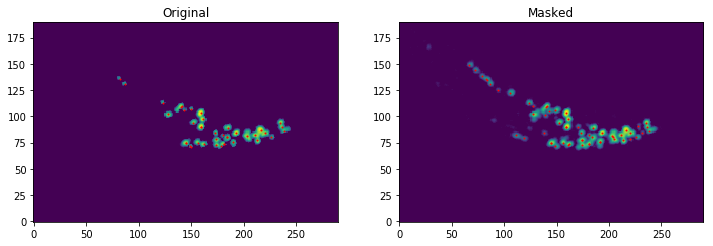

In [60]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(np.log(np.mean(originals[t],axis=2)+1).T,origin="below")
po=get3dpeaks(originals[t],1)
plt.scatter(*po[:,:2].T,c="r",s=1)
plt.title("Original")
plt.subplot(122)
plt.imshow(np.log(np.mean(maskeds[t],axis=2)+1).T,origin="below")
pm=get3dpeaks(maskeds[t],1)
plt.scatter(*pm[:,:2].T,c="r",s=1)
plt.title("Masked")
print("Original:",len(po),"peaks.   Masked:",len(pm),"peaks.")

Process all frames

In [31]:
peaksso=[]
peakssm=[]
for i,im in enumerate(originals):
    print("\r "+str(i),end="")
    try:
        peaks=get3dpeaks(im,thres=1)
        peaksso.append(peaks)
    except:
        peaksso.append([])
for i,im in enumerate(maskeds):
    print("\r "+str(i),end="")
    try:
        peaks=get3dpeaks(im,thres=1)
        peakssm.append(peaks)
    except:
        peakssm.append([])

 3001

Plot the number of detected peaks

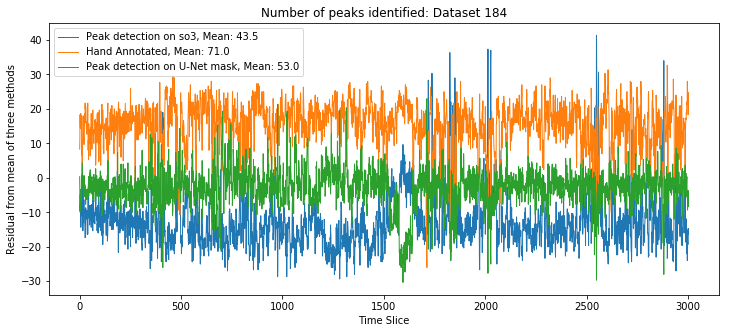

In [32]:
plt.figure(figsize=(12,5))
numso=np.array([len(peaks) for peaks in peaksso])
numsm=np.array([len(peaks) for peaks in peakssm])
numseg=np.array([len(peaks) for peaks in ptds])
mean=(numso+numsm+numseg)/3
plt.plot(numso-mean,label="Peak detection on so3, Mean: "+str(np.round(np.mean(numso),1)),lw=1)
plt.plot(numseg-mean,label="Hand Annotated, Mean: "+str(np.round(np.mean(numseg),1)),lw=1)
plt.plot(numsm-mean,label="Peak detection on U-Net mask, Mean: "+str(np.round(np.mean(numsm),1)),lw=1)
plt.ylabel("Residual from mean of three methods")
plt.xlabel("Time Slice")
plt.title("Number of peaks identified: Dataset 184")
plt.legend()

Histogram

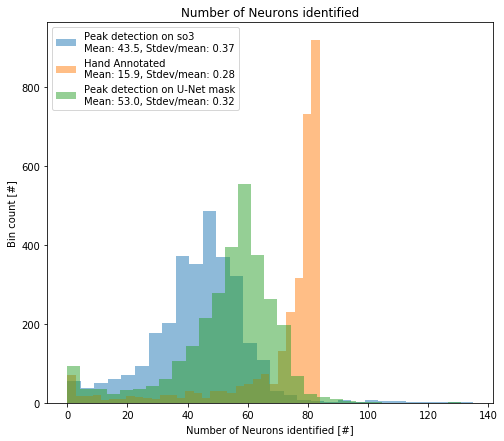

In [33]:
plt.figure(figsize=(8,7))
_=plt.hist(numso,bins=30,alpha=0.5,label="Peak detection on so3\nMean: "+str(np.round(np.mean(numso),1))+", Stdev/mean: "+str(np.round(np.std(numso)/np.mean(numso),2)))
_=plt.hist(numseg,bins=30,alpha=0.5,label="Hand Annotated\nMean: "+str(np.round(np.std(numso),1))+", Stdev/mean: "+str(np.round(np.std(numseg)/np.mean(numseg),2)))
_=plt.hist(numsm,bins=30,alpha=0.5,label="Peak detection on U-Net mask\nMean: "+str(np.round(np.mean(numsm),1))+", Stdev/mean: "+str(np.round(np.std(numsm)/np.mean(numsm),2)))
plt.ylabel("Bin count [#]")
plt.xlabel("Number of Neurons identified [#]")
plt.title("Number of Neurons identified")
plt.legend()

Save the detected peaks

In [23]:
#np.save("./data/peaks/peaks-184FromSegnetv1",peakssm)
#np.save("./data/peaks/peaks-184Froms2",peaksso)

Below is not used, but it is here for plotting all projections

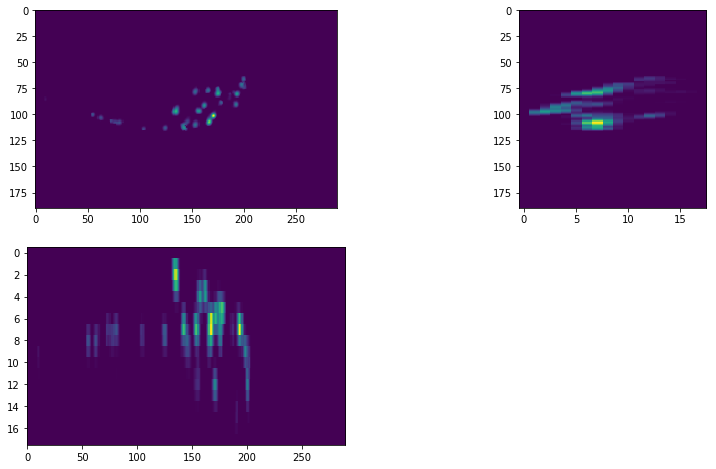

In [246]:
showim=im
plt.rcParams["figure.figsize"] = (14,8)
plt.subplot(2,2,1)
plt.imshow(np.mean(showim,axis=2).T)
#plt.scatter(*peaks[:,:2].T,c="r",s=1)
plt.subplot(2,2,2)
plt.imshow(np.mean(showim,axis=0),aspect=0.1)
#plt.scatter(peaks[:,2],peaks[:,1],c="r",s=1)
plt.subplot(2,2,3)
plt.imshow(np.mean(showim,axis=1).T,aspect=10)
#plt.scatter(peaks[:,0],peaks[:,2],c="r",s=1)

In [6]:
t=np.random.randint(0,3002)

43 54 Hand: 83


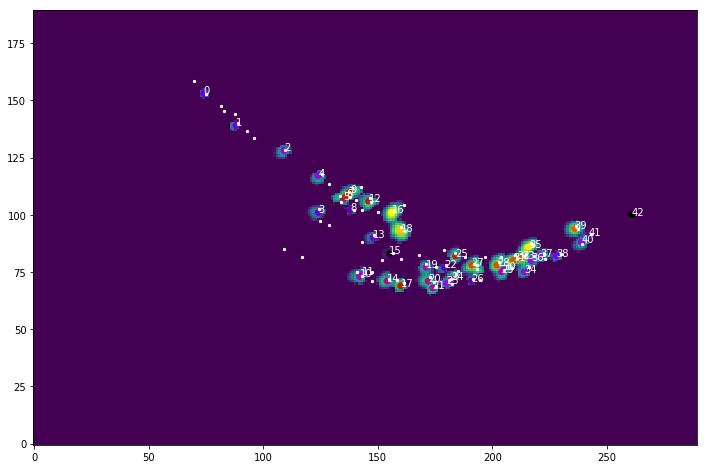

In [10]:
plt.rcParams["figure.figsize"] = (14,8)
im=allimages[t]
peaks,mags=get_simplecluster(np.mean(im,axis=2)+np.random.normal(0,0.01,size=im.shape[:2]),0.07)
normmags=(mags-np.min(mags))/(np.max(mags)-np.min(mags))
peaks3d,columndensities=zresolve(im+np.random.uniform(size=im.shape)*0.01,peaks,mags)
plt.imshow(np.log(np.mean(im,axis=2).T+1), origin="below")
cmap=matplotlib.cm.get_cmap('gnuplot')
plt.scatter(*peaks.T,c=cmap(normmags))
plt.scatter(*ptd[t][:,:2].T,c="w",s=5)
for i,peak in enumerate(peaks):
    plt.annotate(str(i),peak,color="white")
print(len(peaks),len(peaks3d),"Hand:",len(ptd[t]))